# **FinBERT**
The following notebook tests a variety of FinBERT configurations and variants, particularly Hierarchical FinBERT (**HFinBERT**) with WordNet for word embeddings. It will also utilize a Combined User-defined Loss Functions (Focal Loss and Weighted Cross-Entropy Loss), and Temporal and Stock Data (which are the timestamp and stock name).

In [16]:
import os
import json
import torch
import pandas as pd
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

### (SHARED) Model and Dataset Parameters

In [2]:
from helpers import *
from models import train_hbert, WeightedFocalLoss

# Model hyperparameters
max_chunk_length = 256
max_chunks = 8
batch_size = 16
num_epochs = 10
num_h_epochs = 45
learning_rate = 2e-5
aggregation_method = 'attention'
early_stopping_patience = 6
use_wordnet = True
focal_gamma = 2.0
max_len = 128

# dataset and dataloaders
df = pd.read_csv(dataset_path)
train_datasets, val_datasets, test_datasets = get_split_datasets(
    df, use_wordnet=use_wordnet, max_chunk_length=max_chunk_length, max_chunks=max_chunks,
    flag='finbert',
)
train_loader, train_df = train_datasets
val_loader, val_df = val_datasets
test_loader, test_df = test_datasets
num_stocks = len(df[stock].unique())

NLTK resource download complete


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


CUDA device detected!



### **Run Above**

# 1. FinBERT Baseline

### Inference Baseline FinBERT and Evaluate

In [3]:
# Define baseline model
baseline_model = BertForSequenceClassification.from_pretrained(
    'yiyanghkust/finbert-tone', num_labels=num_labels, ignore_mismatched_sizes=True
)
print_evaluation_report(test_loader, model=baseline_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
              precision    recall  f1-score   support

    decrease       0.57      0.44      0.50       366
    increase       0.38      0.51      0.43       249

    accuracy                           0.47       615
   macro avg       0.47      0.47      0.46       615
weighted avg       0.49      0.47      0.47       615

Accuracy: 0.4667


# 2. Model Training

### Helper Functions

In [7]:
def finetune_finbert(
    train_loader, num_labels, learning_rate, n_epochs, batch_size, max_len, save_dir
):
    log_file = os.path.join(save_dir, 'training_log.json')
    os.makedirs(save_dir, exist_ok=True)

    # Load tokenizer
    if os.path.exists(os.path.join(save_dir, 'tokenizer_config.json')):
        print("Loading saved tokenizer...")
        tokenizer = BertTokenizer.from_pretrained(save_dir)
    else:
        print("Loading base FinBERT tokenizer...")
        tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

    # Load model
    if os.path.exists(os.path.join(save_dir, 'pytorch_model.bin')):
        print("Loading existing fine-tuned model...")
        model = BertForSequenceClassification.from_pretrained(save_dir)
    else:
        print("Loading base FinBERT model...")
        model = BertForSequenceClassification.from_pretrained(
            'yiyanghkust/finbert-tone',
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )

    # Load log or start fresh
    if os.path.exists(log_file):
        with open(log_file, 'r') as f:
            log = json.load(f)
        start_epoch = log.get('last_epoch', 0) + 1
    else:
        log = {
            'last_epoch': 0,
            'hyperparameters': {
                'batch_size': batch_size,
                'max_len': max_len,
                'learning_rate': learning_rate,
                'num_labels': num_labels,
                'focal_gamma': focal_gamma
            }
        }
        start_epoch = 1
    print(f"Resuming training from epoch {start_epoch}")
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    model.to(device)

    for epoch in range(start_epoch, start_epoch + n_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch} | Training Loss: {avg_loss:.4f}")
        model.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)

        log['last_epoch'] = epoch
        with open(log_file, 'w') as f:
            json.dump(log, f)
    print(f"Training complete. Saved to {save_dir}")


def finetune_finbert_with_custom_loss(
    train_loader, num_labels, learning_rate, n_epochs, loss_fn, batch_size, max_len, save_dir
):
    log_file = os.path.join(save_dir, 'training_log.json')
    os.makedirs(save_dir, exist_ok=True)

    # Load tokenizer
    if os.path.exists(os.path.join(save_dir, 'tokenizer_config.json')):
        print("Loading saved tokenizer...")
        tokenizer = BertTokenizer.from_pretrained(save_dir)
    else:
        print("Loading base FinBERT tokenizer...")
        tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

    # Load model
    if os.path.exists(os.path.join(save_dir, 'pytorch_model.bin')):
        print("Loading existing fine-tuned model...")
        model = BertForSequenceClassification.from_pretrained(save_dir)
    else:
        print("Loading base FinBERT model...")
        model = BertForSequenceClassification.from_pretrained(
            'yiyanghkust/finbert-tone',
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
    
    # Load log or start fresh
    if os.path.exists(log_file):
        with open(log_file, 'r') as f:
            log = json.load(f)
        start_epoch = log.get('last_epoch', 0) + 1
    else:
        log = {
            'last_epoch': 0,
            'hyperparameters': {
                'batch_size': batch_size,
                'max_len': max_len,
                'learning_rate': learning_rate,
                'num_labels': num_labels,
                'focal_gamma': focal_gamma
            }
        }
        start_epoch = 1
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(start_epoch, start_epoch + n_epochs):
        model.train()
        total_loss = 0.0
        all_preds = []
        all_labels = []

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Loss calculation
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Backprop and update
            loss.backward()
            optimizer.step()

            # Predictions
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Epoch metrics
        acc = accuracy_score(all_labels, all_preds)
        avg_loss = total_loss / len(train_loader)

        print(f"Epoch {epoch} | Training Loss: {avg_loss:.4f}")

        # Save model and tokenizer
        model.save_pretrained(save_dir)
        tokenizer.save_pretrained(save_dir)

        # Update training log
        log['last_epoch'] = epoch
        with open(log_file, 'w') as f:
            json.dump(log, f)

    print(f"Training complete. Saved to {save_dir}")

### Training including the stockname with the datetime

#### Training with Default Loss Function

In [10]:
save_dir = model_path + './finbert/default_loss'
finetune_finbert(
    train_loader=train_loader,
    num_labels=num_labels,
    learning_rate=learning_rate,
    n_epochs=num_epochs,
    batch_size=batch_size,
    max_len=max_len,
    save_dir=save_dir
)

Loading base FinBERT tokenizer...
Loading base FinBERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resuming training from epoch 1
Epoch 1 | Training Loss: 0.7137
Epoch 2 | Training Loss: 0.6917
Epoch 3 | Training Loss: 0.6833
Epoch 4 | Training Loss: 0.6824
Epoch 5 | Training Loss: 0.6783
Epoch 6 | Training Loss: 0.6758
Epoch 7 | Training Loss: 0.6773
Epoch 8 | Training Loss: 0.6771
Epoch 9 | Training Loss: 0.6742
Epoch 10 | Training Loss: 0.6723
Training complete. Saved to .models./finbert/default_loss


In [12]:
print_evaluation_report(test_loader, Model=BertForSequenceClassification, model_dir=save_dir)

Classification Report:
              precision    recall  f1-score   support

    decrease       0.60      1.00      0.75       366
    increase       0.00      0.00      0.00       249

    accuracy                           0.60       615
   macro avg       0.30      0.50      0.37       615
weighted avg       0.35      0.60      0.44       615

Accuracy: 0.5951


#### Save to .pt model for evaluation

In [14]:
from helpers.model import save_model

log_dir = os.path.join(save_dir, 'training_log.json')
with open(log_dir, 'r') as f:
    log = json.load(f)

save_model(
    model=BertForSequenceClassification.from_pretrained(save_dir, num_labels=num_labels),
    model_config=log,
    save_dir=save_dir + '/pytorch',
    tokenizer=BertTokenizer.from_pretrained(save_dir)
)

Model successfully saved to .models./finbert/default_loss/pytorch


'.models./finbert/default_loss/pytorch'

#### Training with Custom Loss Function

In [15]:
save_dir = model_path + './finbert/custom_loss'
finetune_finbert(
    train_loader=train_loader,
    num_labels=num_labels,
    learning_rate=learning_rate,
    n_epochs=num_epochs,
    batch_size=batch_size,
    max_len=max_len,
    save_dir=save_dir
)

Loading base FinBERT tokenizer...
Loading base FinBERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resuming training from epoch 1
Epoch 1 | Training Loss: 0.7039
Epoch 2 | Training Loss: 0.6863
Epoch 3 | Training Loss: 0.6836
Epoch 4 | Training Loss: 0.6877
Epoch 5 | Training Loss: 0.6786
Epoch 6 | Training Loss: 0.6783
Epoch 7 | Training Loss: 0.6752
Epoch 8 | Training Loss: 0.6750
Epoch 9 | Training Loss: 0.6733
Epoch 10 | Training Loss: 0.6764
Training complete. Saved to .models./finbert/custom_loss


In [18]:
print_evaluation_report(test_loader, Model=BertForSequenceClassification, model_dir=save_dir)

Classification Report:
              precision    recall  f1-score   support

    decrease       0.60      1.00      0.75       366
    increase       0.00      0.00      0.00       249

    accuracy                           0.60       615
   macro avg       0.30      0.50      0.37       615
weighted avg       0.35      0.60      0.44       615

Accuracy: 0.5951


#### Save to .pt model for evaluation

In [20]:
log_dir = os.path.join(save_dir, 'training_log.json')
with open(log_dir, 'r') as f:
    log = json.load(f)

save_model(
    model=BertForSequenceClassification.from_pretrained(save_dir, num_labels=num_labels),
    model_config=log,
    save_dir=save_dir + '/pytorch',
    tokenizer=BertTokenizer.from_pretrained(save_dir)
)

Model successfully saved to .models./finbert/custom_loss/pytorch


'.models./finbert/custom_loss/pytorch'

### **Run Below**

## Hierarchical FinBERT

In [21]:
class HierarchicalFINBERTStockPredict(nn.Module):
    """
    Hierarchical FINBERT for Stock Prediction.
    """
    def __init__(
        self, num_labels=3, max_chunk_length=256, aggregation_method='attention',
        num_stocks=10, stock_embedding_dim=16
    ):
        super().__init__()
        self.model = BertForSequenceClassification.from_pretrained(
            'yiyanghkust/finbert-tone', num_labels=num_labels, ignore_mismatched_sizes=True
        )
        self.hidden_size = self.model.config.hidden_size

        self.pooler = nn.Linear(self.hidden_size, self.hidden_size)
        self.pooler_activation = nn.Tanh()
        self.aggregation_method = aggregation_method
        if aggregation_method == 'attention':
            self.attention = nn.Linear(self.hidden_size, 1)

        self.temporal_embedding = nn.Linear(1, 32)
        self.temporal_activation = nn.Tanh()
        self.stock_embedding = nn.Embedding(num_stocks, stock_embedding_dim)
        combined_dim = self.hidden_size + 32 + stock_embedding_dim

        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )
        self.max_chunk_length = max_chunk_length

    def forward(self, input_ids_list, attention_mask_list, time_values, stock_indices):
        """
        Forward pass with consideration to time and stock. Uses a variety of techniques such
        as dropout.
        """
        batch_size = len(input_ids_list)
        chunk_embeddings = []

        for i in range(batch_size):
            example_chunks = []
            for j in range(len(input_ids_list[i])):
                # get the output of last hidden state
                out = self.model(
                    input_ids=input_ids_list[i][j].unsqueeze(0),
                    attention_mask=attention_mask_list[i][j].unsqueeze(0),
                    output_hidden_states=True
                )
                cls = out.hidden_states[-1][:, 0, :]
                # pooled and append to example chunks
                pooled = self.pooler(cls)
                pooled = self.pooler_activation(pooled)
                example_chunks.append(pooled)

            stacked = torch.cat(example_chunks, dim=0)
            if self.aggregation_method == 'mean':
                aggregated = torch.mean(stacked, dim=0, keepdim=True)
            elif self.aggregation_method == 'max':
                aggregated = torch.max(stacked, dim=0, keepdim=True)[0]
            elif self.aggregation_method == 'attention':
                attn_weights = torch.softmax(self.attention(stacked), dim=0)
                aggregated = torch.sum(stacked * attn_weights, dim=0, keepdim=True)
            chunk_embeddings.append(aggregated)

        text_embeddings = torch.cat(chunk_embeddings, dim=0)
        time_embeddings = self.temporal_activation(self.temporal_embedding(time_values.unsqueeze(1)))
        stock_embeddings = self.stock_embedding(stock_indices)

        combined = torch.cat([text_embeddings, time_embeddings, stock_embeddings], dim=1)
        combined = self.dropout(combined)
        return self.classifier(combined)

### HBERT Dataset

In [22]:
train_datasets, val_datasets, test_datasets = get_split_datasets(
    df, use_wordnet=use_wordnet, max_chunk_length=max_chunk_length, max_chunks=max_chunks
)
train_loader, train_df = train_datasets
val_loader, val_df = val_datasets
test_loader, test_df = test_datasets

### Training Results

In [ ]:
model = HierarchicalFINBERTStockPredict(
    num_labels=num_labels, max_chunk_length=max_chunk_length,
    aggregation_method=aggregation_method, num_stocks=num_stocks,
)
train_hbert(
    model, train_loader, test_loader, device, loss_fn=WeightedFocalLoss,
    num_epochs=num_h_epochs, learning_rate=learning_rate, focal_gamma=focal_gamma
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and data prepared. Ready to train!


### Save Model

In [23]:
model = HierarchicalFINBERTStockPredict(
    num_labels=num_labels, max_chunk_length=max_chunk_length,
    aggregation_method=aggregation_method, num_stocks=num_stocks,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Save the trained model
save_dir = model_path + './hfinbert'

model_config = {
    'num_labels': model.classifier[-1].out_features,
    'max_chunk_length': model.max_chunk_length,
    'aggregation_method': model.aggregation_method,
    'num_stocks': model.stock_embedding.num_embeddings,
    'stock_embedding_dim': model.stock_embedding.embedding_dim
}
save_path = save_model(model, model_config, save_dir)
print(f"Model saved to: {save_path}")

Model successfully saved to .models./hfinbert
Model saved to: .models./hfinbert


In [25]:
save_dir = model_path + './hfinbert'
model, tokenizer = load_model(HierarchicalFINBERTStockPredict, save_dir)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model successfully loaded from .models./hfinbert


# 3. In-depth Performance Evaluation

Skipping BX - insufficient test samples (4)
Skipping F - insufficient test samples (3)
Skipping NOC - insufficient test samples (3)
Error calculating metrics for VZ: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

=== Overall Performance ===
Accuracy: 0.5951
F1 Score: 0.4527

Confusion Matrix:
[[363   3]
 [246   3]]

=== Stock Performance Ranking (by F1 Score) ===
Stock  Accuracy  Precision   Recall  F1 Score  Samples
   KO  0.904762   0.818594 0.904762  0.859524     21.0
 INTC  0.840000   0.770000 0.840000  0.803478     25.0
   PG  0.837838   0.701972 0.837838  0.763911     37.0
  TSM  0.675676   0.783784 0.675676  0.569112     37.0
 MSFT  0.648649   0.420745 0.648649  0.510412     37.0
  CRM  0.619048   0.383220 0.619048  0.473389     21.0
 META  0.600000   0.360000 0.600000  0.450000     20.0
  AMD  0.594595   0.353543 0.594595  0.443426     37.0
  DIS  0.590909   0.349174 0.590909  0.438961     22.0
  NIO  0.567568   0.322133 0.567

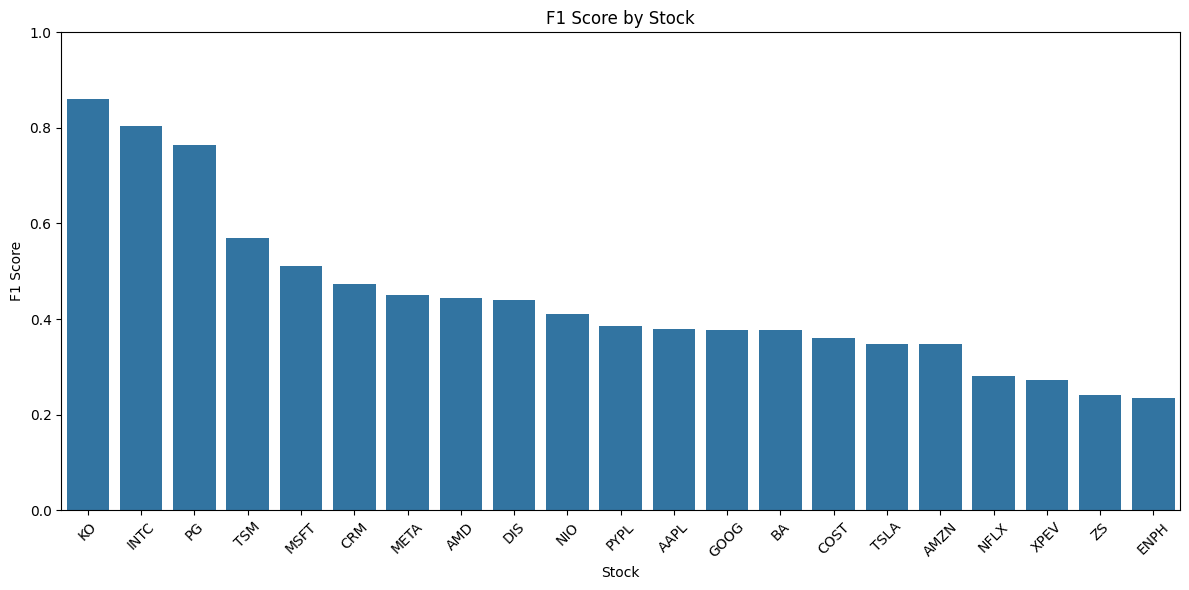

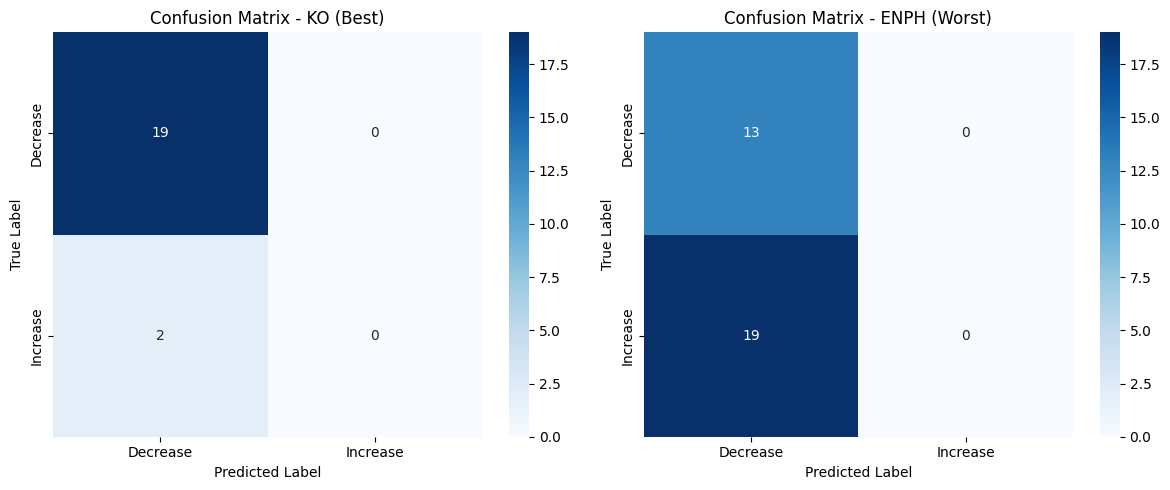


=== High Confidence Error Cases ===

Stock: TSLA
Text: Fremont update: Cars sticking out of every nook and cranny; 20 car carriers hauling vehicles away from the logistics lot. Busy factory. Also, possible...
True Label: Increase
Predicted: Decrease (Confidence: 0.56)
--------------------------------------------------

Stock: TSLA
Text: $TSLA - Over 900 - Trade Idea - Aug 19th 970C Closed at 900.09 If TSLA can hold above 900 this week it should test 945-964 next Calls can work above 9...
True Label: Increase
Predicted: Decrease (Confidence: 0.55)
--------------------------------------------------

Stock: TSLA
Text: $TSLA - Under 285 - Trade Idea - Sept 2 275P Closed at 288.09 TSLA under 285 can pull back to 280, 273 Puts can work under 285 or if TSLA pops to 296 ...
True Label: Increase
Predicted: Decrease (Confidence: 0.55)
--------------------------------------------------

Stock: TSLA
Text: Here's the intro of today's MarketOutlook video from @MarketScholars Watch the full video fo

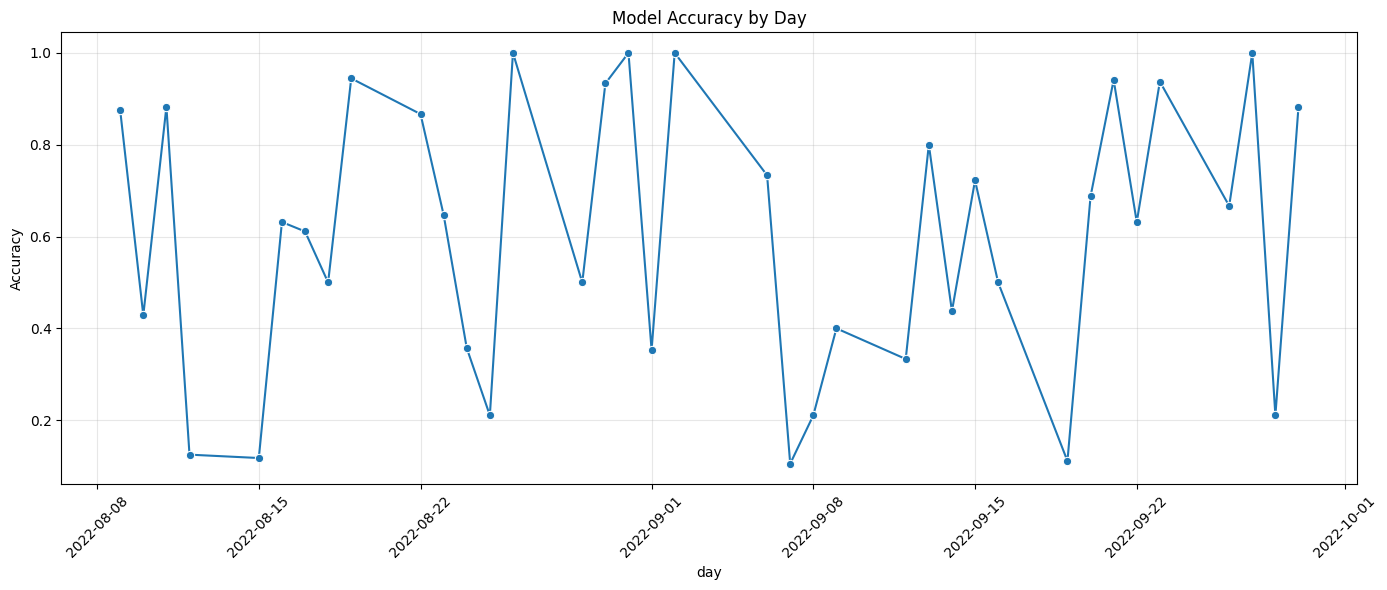

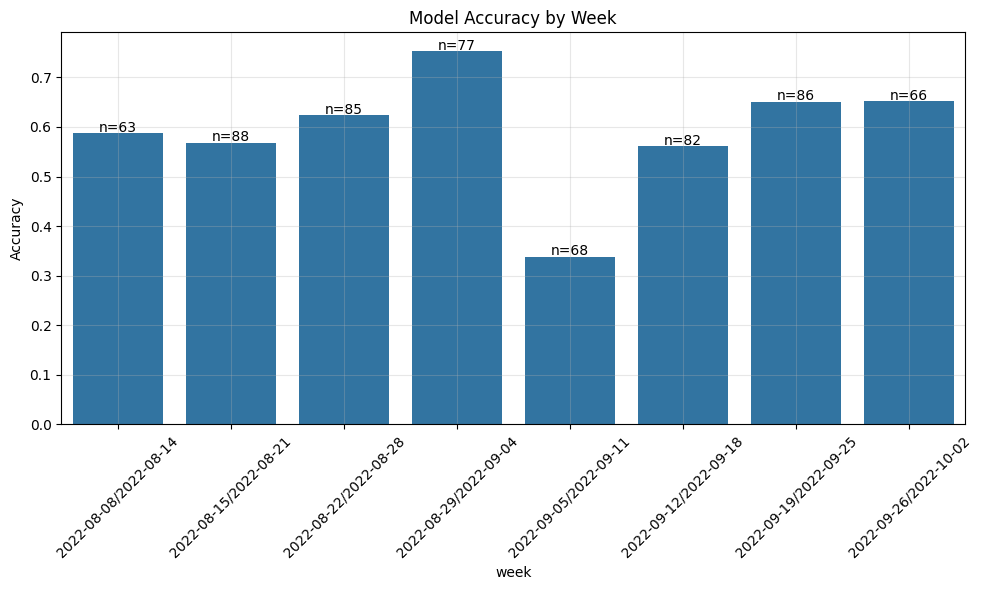


=== Worst Performing days ===
day: 2022-09-07 00:00:00, Accuracy: 0.11, Samples: 19
day: 2022-09-19 00:00:00, Accuracy: 0.11, Samples: 18
day: 2022-08-15 00:00:00, Accuracy: 0.12, Samples: 17


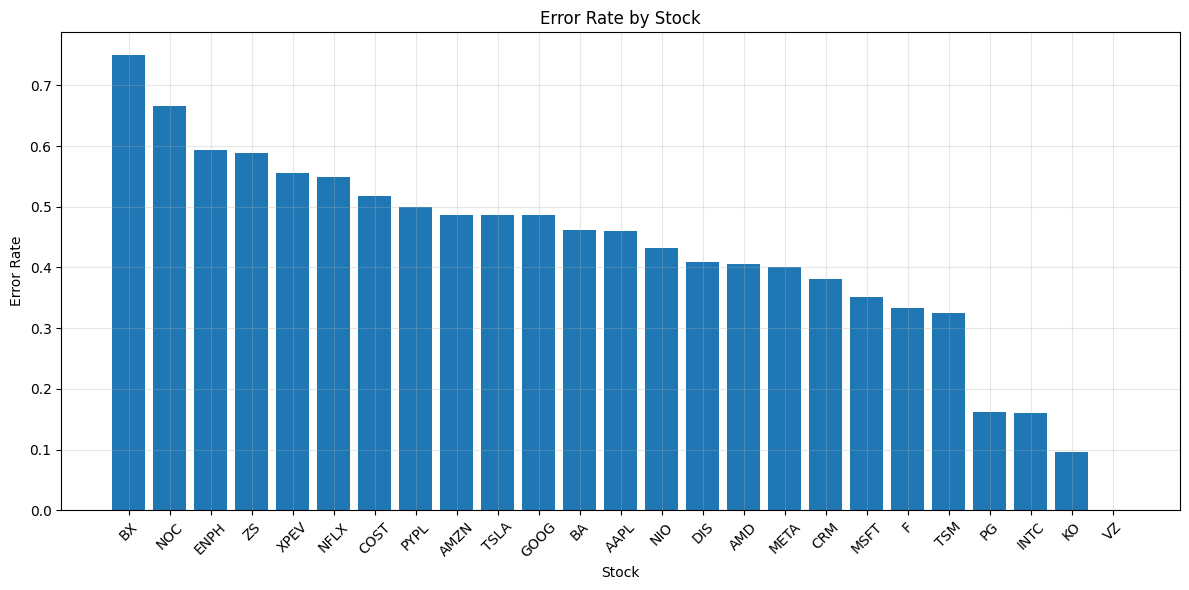


=== Stock-Specific Error Analysis ===

Stock: BX - Error Rate: 0.75
Number of errors: 3 out of 4 samples
Common words in error cases:
  - 'bx': 4 occurrences
  - 'url': 3 occurrences
  - 'project': 2 occurrences
  - 'maybe': 1 occurrences

Example error cases:
  - True: Increase, Predicted: Decrease
    Text: Maybe a project's happiness is hearing their token get in the Top Traded This weeks glory is for $RAIN $IMT $WEAR C98 $RUX $LOVELY $BX BABYDOGE $AURA ...

  - True: Increase, Predicted: Decrease
    Text: $BX thesis per Edgewood: 1) $120T TAM 2) 90% retention among existing LPs driven by brand strength 3) Global scale 4) Improving earnings quality given...


Stock: NOC - Error Rate: 0.67
Number of errors: 2 out of 3 samples
Common words in error cases:
  - 'noc': 2 occurrences
  - 'enph': 2 occurrences
  - 'averages': 1 occurrences
  - 'pulling': 1 occurrences
  - 'back': 1 occurrences
  - 'from': 1 occurrences
  - 'logical': 1 occurrences
  - 'supply': 1 occurrences
  - 'near': 

In [29]:
eval_results = evaluate_model_by_stock(
    model, test_loader, test_df, stock_column=stock, post_column=post
)

# run time-based analysis
print("\n\n=== Time-Based Performance Analysis ===")
_ = analyze_performance_by_time(eval_results['results_df'], date_column=date)

# run stock-specific error analysis
_ = analyze_stock_specific_errors(eval_results['results_df'], stock_column=stock, post_column=post)